# Neural Network to Identify Handwritten Digits
## Background information
**Project Goal:**<br>
The goal of this project was to get some exposure to neural networks by completing a relatively basic function. At the end of this document I will reflect on the learning process. 

**MNIST Data Set:**<br>
For this project I am going to be using the very common MNIST data set. The data comes with 2 seperate csv files, one for training the neural network and then one for testing its accuracy. The data is formatted with one column for the label, representing the correct answer to the digit drawn, followed by 784 rows of pixel data. The pixel data ranges from 0-255 so in the code it had to be normalised from 0-1. An example image of the digits can be seen below:<br>
<br><img src = "images\MnistExamplesModified.png">


**Neural Networks:**<br>
Neural Networks are a learning model inspired by the function of biological processes in the brains of animals. Neural networks operate by having multiple layers of neurons. For each neuron in a layer, there is a specific weighting and bias which it places on the data being input to it. By starting with random weightings and biases, making some guesses, and then comparing the guesses to the correct answers, the network changes itself by altering the weightings and biases of the input data. In addition to this, after processing the data, an activation function can be applied before moving onto the next layer in order to expand the possible outputs to more complex solutions rather than just linear ones. <br>

Now for the code:

First, import neccessary libraries:

In [37]:
'''Import neccessary libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Next, as the csv file type is not the best for mathematical operations, a function to convert the input data into a numpy array must be coded and can be seen below:

In [38]:
'''Convert a csv file to an array for analysing'''
def convert_csv_to_array(filepath):
    df = pd.read_csv(filepath, dtype=int)
    data = np.array(df)
    x,y = data.shape
    data = data.T

    answers = data[0]
    pixels = data[1:y]/255.0 #Normalise pixel data 

    return answers, pixels, x, y

As explained above, the first set of weightings and biases are randomly assigned within a range of [-0.5,0.5]. A function to initialise said parameters is coded below:

In [39]:
'''Initialise starting weights and biases with random values from [-0.5,0.5]'''
def init_parameters(nodes):
    weights1 = np.random.rand(nodes,784) - 0.5
    biases1 = np.random.rand(nodes,1) - 0.5
    weights2 = np.random.rand(10,nodes) - 0.5
    biases2 = np.random.rand(10,1) - 0.5

    return weights1, biases1, weights2, biases2

Next are the activation functions required in order to be applied to the output of a layer in the network. Also included is a softmax function for converting the output into an array of probabilities in order to compare to the actual answers. Also included is a one hot encoding function to convert the answer of any given example in the same format as the softmax function output which will have probability 1 of the digit to which the drawn number is.

In [40]:
'''Below are all the activation functions required for the training'''
def activation(value):
    return np.maximum(0, value) #Relu
    # return np.where(value >= 0, value, 0.1*value) # Leaky ReLU
    # return (np.exp(value) - np.exp(-value)) / (np.exp(value) + np.exp(-value)) # Tanh
    # return 1.0 / (1.0 + np.exp(-value)) # Sigmoid

def delta_activation(value):
    return value > 0
    # return np.where(value >= 0, 1, 0.1) # Leaky ReLU
    # return 1.0 - np.power(activation(value),2) # Tanh
    # return activation(value)*(1.0 - activation(value)) # Sigmoid

def softmax(value):
    return np.exp(value)/sum(np.exp(value))

def one_hot(answers):
    one_hot = np.zeros((answers.size, answers.max()+1))
    one_hot[np.arange(answers.size), answers] = 1
    #Transpose so each column is an example
    one_hot = one_hot.T
    return one_hot

Next, it's time for forward propogation. Forward propogation is the function which takes some values for weightings and biases of each layer in the neural network, and works forwards. At each layer of neurons, the forward propogation function multiplies the weightings of each neuron with their input, then adds the bias for said neuron. After this, it applies the activation function shown above and feeds this as an input into the next layer of the network.

In [41]:
'''Run forward through the network once, based on input weights and biases for each layer'''
def forward_propogation(weights1, biases1, weights2, biases2, input):
    layer1 = weights1.dot(input) + biases1 
    activated_layer1 = activation(layer1)
    layer2 = weights2.dot(activated_layer1) + biases2
    activated_layer2 = softmax(layer2)

    return layer1, activated_layer1, layer2, activated_layer2

With forward propgation coded, now it's time for backwards propogation. As briefly touched on above, backwards propogation involves comparing the output of the forward propogation with the actual answers. By comparing them, and figuring out exactly how wrong the network was, backwards prop works backwards through the layers, adjusting the weights and biases based on how wrong it was, and multiplying this error by some learning rate. The learning rate is the extent to which backwards prop will shift the weights and biases based on how wrong they were.

In [42]:
'''Run backwards through the network once, calculating the error at each stage and the altering the weights and biases based on how wrong each step was'''
def backwards_propogation(data, layer1, layer2, activated_layer1, activated_layer2, weights1, weights2, biases1, biases2, answers, learning_rate, a):
    one_hot_answers = one_hot(answers) 

    error_layer2 = activated_layer2 - one_hot_answers
    error_weightings2 = 1/a*error_layer2.dot(activated_layer1.T)
    error_biases2 = 1/a*np.sum(error_layer2)

    error_layer1 = weights2.T.dot(error_layer2)*delta_activation(layer1)
    error_weightings1 = 1/a*error_layer1.dot(data.T)
    error_biases1 = 1/a*np.sum(error_layer1)

    weights1 -= learning_rate*error_weightings1
    biases1 -= learning_rate*error_biases1
    weights2 -= learning_rate*error_weightings2
    biases2 -= learning_rate*error_biases2

    return weights1, biases1, weights2, biases2

With these functions now coded, the focus can shift towards actually generating and training the network. This function is relatively simple, running through forward and then back prop for a certain number of iterations and returning the final values for all the weighs and biases for the nodes in the neuron layers. 

In [43]:
def train_network(data, answers, iterations, learning_rate, nodes, a):
    #Initialise random weights and biases to begin
    weights1, biases1, weights2, biases2 = init_parameters(nodes)

    #Iterate through forward prop and back prop changing the weights and biases each time
    for x in range(iterations):
        layer1, activated_layer1, layer2, activated_layer2 = forward_propogation(weights1, biases1, weights2, biases2, data)
        weights1, biases1, weights2, biases2 = backwards_propogation(data, layer1, layer2, activated_layer1, activated_layer2, weights1, weights2, biases1, biases2, answers, learning_rate, a)

    return weights1, biases1, weights2, biases2


Before we can test the results of the neural network, a couple functions for assessing the accuracy of the predictions must be coded.

In [44]:
'''Return the integer predicted by the network. The prediction is the value with the highest probability'''
def prediction(activated_layer2):
    return np.argmax(activated_layer2, 0)

'''Calculate the accuracy of the network with the current set of predictions'''
def accuracy(prediction, answer):
    return np.sum(prediction == answer)/answer.size

Next, a function which tests any set of weights and biases against the testing data from the MNIST set.

In [45]:
def test_network(data, answers, weights1, weights2, biases1, biases2):
    layer1, activated_layer1, layer2, activated_layer2 = forward_propogation(weights1, biases1, weights2, biases2, data)
    return accuracy(prediction(activated_layer2), answers)

With all of that coded in, an initial test of the network can be done. First, let's import the data with the function coded at the start and initialise some key variables.

In [46]:
#Import data for training and testing
train_sol, train_data, a, b = convert_csv_to_array("MNIST_DATA/mnist_train.csv")
test_sol, test_data, c, d = convert_csv_to_array("MNIST_DATA/mnist_test.csv")

#BELOW VALUES CAN BE CHANGED
learning_rate = 0.1 #Rate at which the errors are factored into weights and biases
iterations = 500 #Times the nerual network will iterate and change weights + biases
nodes = 15 #Number of nodes in the first layer

Now lets train the network! (This wil take some time depending on the variables assigned above)

In [47]:
#Train Network
weights1, biases1, weights2, biases2 = train_network(train_data, train_sol, iterations, learning_rate, nodes, a)

With the resulting weights and biases, now we can test it against the data set put aside at the beginning.

In [48]:
trained_accuracy = test_network(test_data, test_sol, weights1, weights2, biases1, biases2)
print(f"Accuracy: {round(100*trained_accuracy,2)}%")

Accuracy: 85.79%


Perfect! When I ran this myself with more iterations the accuracy asymptoted at around 91%. Finding the total accuracy at the end of the simulation is good, but what about assessing the running accuracy over time? To do this lets alter some of the above functions.

In [52]:
def train_network2(data, answers, iterations, learning_rate, nodes, a):
    #Initialise random weights and biases to begin
    weights1, biases1, weights2, biases2 = init_parameters(nodes)
    accuracies = []
    itt = []

    #Iterate through forward prop and back prop changing the weights and biases each time
    for x in range(iterations):
        layer1, activated_layer1, layer2, activated_layer2 = forward_propogation(weights1, biases1, weights2, biases2, data)
        accuracies.append(test_network(data, answers, weights1, weights2, biases1, biases2))
        itt.append(x)
        weights1, biases1, weights2, biases2 = backwards_propogation(data, layer1, layer2, activated_layer1, activated_layer2, weights1, weights2, biases1, biases2, answers, learning_rate, a)

    return weights1, biases1, weights2, biases2, accuracies, itt

In [53]:
#Train Network
weights1, biases1, weights2, biases2, acc, itt = train_network2(train_data, train_sol, iterations, learning_rate, nodes, a)

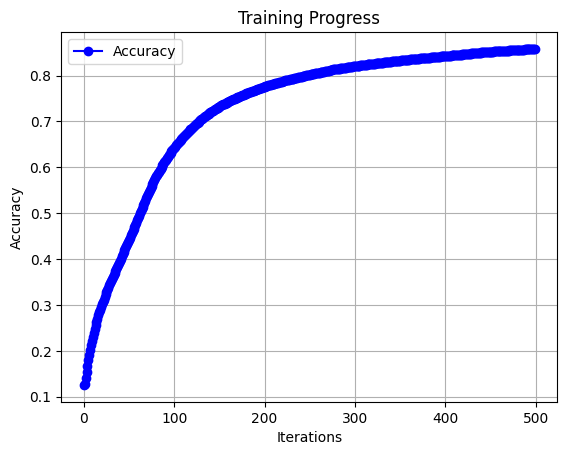

In [57]:
def plot_training_progress(itt, acc):
    
    plt.plot(itt, acc, label='Accuracy', color='b', marker='o', linestyle='-')
    plt.title('Training Progress')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to plot_training_progress function
plot_training_progress(itt, acc)

As an additional research idea, I will test different actication functions and compare their accuracies. First Tanh.

In [59]:
def activation(value):
    # return np.maximum(0, value) #Relu
    # return np.where(value >= 0, value, 0.1*value) # Leaky ReLU
    return (np.exp(value) - np.exp(-value)) / (np.exp(value) + np.exp(-value)) # Tanh
    # return 1.0 / (1.0 + np.exp(-value)) # Sigmoid

def delta_activation(value):
    # return value > 0
    # return np.where(value >= 0, 1, 0.1) # Leaky ReLU
    return 1.0 - np.power(activation(value),2) # Tanh
    # return activation(value)*(1.0 - activation(value)) # Sigmoid

weights1, biases1, weights2, biases2 = train_network(train_data, train_sol, iterations, learning_rate, nodes, a)
trained_accuracy = test_network(test_data, test_sol, weights1, weights2, biases1, biases2)
print(f"Accuracy: {round(100*trained_accuracy,2)}%")

Accuracy: 84.41%


Next, Sigmoid.

In [60]:
def activation(value):
    # return np.maximum(0, value) #Relu
    # return np.where(value >= 0, value, 0.1*value) # Leaky ReLU
    # return (np.exp(value) - np.exp(-value)) / (np.exp(value) + np.exp(-value)) # Tanh
    return 1.0 / (1.0 + np.exp(-value)) # Sigmoid

def delta_activation(value):
    # return value > 0
    # return np.where(value >= 0, 1, 0.1) # Leaky ReLU
    # return 1.0 - np.power(activation(value),2) # Tanh
    return activation(value)*(1.0 - activation(value)) # Sigmoid

weights1, biases1, weights2, biases2 = train_network(train_data, train_sol, iterations, learning_rate, nodes, a)
trained_accuracy = test_network(test_data, test_sol, weights1, weights2, biases1, biases2)
print(f"Accuracy: {round(100*trained_accuracy,2)}%")

Accuracy: 75.08%


And Leaky Relu.

In [61]:
def activation(value):
    # return np.maximum(0, value) #Relu
    return np.where(value >= 0, value, 0.1*value) # Leaky ReLU
    # return (np.exp(value) - np.exp(-value)) / (np.exp(value) + np.exp(-value)) # Tanh
    # return 1.0 / (1.0 + np.exp(-value)) # Sigmoid

def delta_activation(value):
    # return value > 0
    return np.where(value >= 0, 1, 0.1) # Leaky ReLU
    # return 1.0 - np.power(activation(value),2) # Tanh
    # return activation(value)*(1.0 - activation(value)) # Sigmoid

weights1, biases1, weights2, biases2 = train_network(train_data, train_sol, iterations, learning_rate, nodes, a)
trained_accuracy = test_network(test_data, test_sol, weights1, weights2, biases1, biases2)
print(f"Accuracy: {round(100*trained_accuracy,2)}%")

Accuracy: 86.99%


After testing all, the Leaky Rectified linear function yielded the highest accuracy. This was all done with 500 iterations for times sake but i think the results would replicate with all increasing their accuracy for more iterations but still having the leaky relu on top.

**Reflection on the Project**
Throughout the project, I think i definitely achieved my goal of exploring and learning about the basics of Neural Networks. Through a lot of video watching and research, I feel my understanding of all the functions above has increased dramatically and I would be equipped to take on an even harder project.